# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 46.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 77.6 MB/s eta 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.ToTensor()

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create test set and define test dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=20)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

*The chosen transform, `transforms.ToTensor()`, is used to convert the MNIST dataset images into tensors, which are the primary data format used by PyTorch. This transformation also scales the pixel values of the images to the range [0, 1], which is a common preprocessing step for neural networks. The transform was chosen to ensure the data is in a suitable format and normalized before being fed into a neural network model.*

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


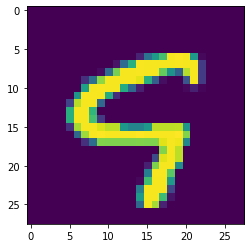

3


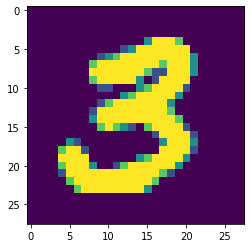

4


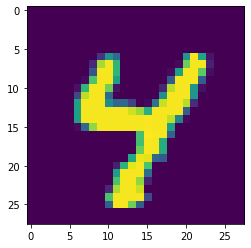

6


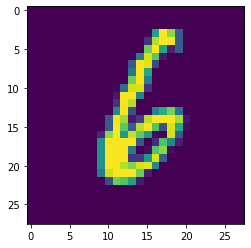

8


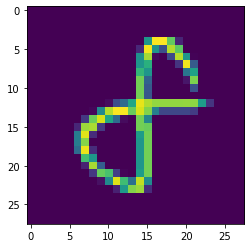

In [6]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
# specify loss function (categorical cross-entropy)
# The chosen loss function, nn.CrossEntropyLoss(), is suitable for multi-class classification tasks like the MNIST dataset. It calculates the cross-entropy loss between the predicted class probabilities and the ground truth labels.
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
print('Training Started')
# number of epochs to train the model
n_epochs = 50

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    for data, target in trainloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
             
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Training Started
Epoch: 1 	Training Loss: 0.839840
Epoch: 2 	Training Loss: 0.325772
Epoch: 3 	Training Loss: 0.249662
Epoch: 4 	Training Loss: 0.202170
Epoch: 5 	Training Loss: 0.168788
Epoch: 6 	Training Loss: 0.145687
Epoch: 7 	Training Loss: 0.127895
Epoch: 8 	Training Loss: 0.113438
Epoch: 9 	Training Loss: 0.102742
Epoch: 10 	Training Loss: 0.094123
Epoch: 11 	Training Loss: 0.085784
Epoch: 12 	Training Loss: 0.079364
Epoch: 13 	Training Loss: 0.072755
Epoch: 14 	Training Loss: 0.067807
Epoch: 15 	Training Loss: 0.061995
Epoch: 16 	Training Loss: 0.058573
Epoch: 17 	Training Loss: 0.054871
Epoch: 18 	Training Loss: 0.051610
Epoch: 19 	Training Loss: 0.048013
Epoch: 20 	Training Loss: 0.045396
Epoch: 21 	Training Loss: 0.043309
Epoch: 22 	Training Loss: 0.039907
Epoch: 23 	Training Loss: 0.037815
Epoch: 24 	Training Loss: 0.035921
Epoch: 25 	Training Loss: 0.033939
Epoch: 26 	Training Loss: 0.032879
Epoch: 27 	Training Loss: 0.030864
Epoch: 28 	Training Loss: 0.029257
Epoch: 29 	T

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for training

for data, target in testloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.052479

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1017/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9841/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [15]:
## YOUR CODE HERE ##
# Model is already optimized.

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'model.pt')